In [1]:
import sys

sys.path.append("../")

## random walk

In [2]:
import json
import os
from pprint import pprint

from src.graph import TYPES_OF_GRAPH, Graph
from src.sample_dialogue import sample_dialogue

path = '../data'

input_path = os.path.join(path, 'theme_graph.json')
graph_dict = json.load(open(input_path, 'r'))
graph = Graph(graph_dict, TYPES_OF_GRAPH.DI)

sampled_dialogue, sampled_base_graph = sample_dialogue(
    graph.nx_graph,
    start_node=1,
    topic='books'
)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
False


In [3]:
pprint(sampled_base_graph)

{'edges': [{'source': 1,
            'target': 2,
            'theme': 'books',
            'utterances': ['I need a book.']},
           {'source': 2,
            'target': 3,
            'theme': 'books',
            'utterances': ['Recommend me a fiction book.']},
           {'source': 3,
            'target': 5,
            'theme': 'books',
            'utterances': ['How about science fiction?']},
           {'source': 5,
            'target': 6,
            'theme': 'books',
            'utterances': ['What are the popular books in this genre?']},
           {'source': 6,
            'target': 7,
            'theme': 'books',
            'utterances': ['Any recommendations for authors?']},
           {'source': 7,
            'target': 8,
            'theme': 'books',
            'utterances': ['Give me the details of this authour.']},
           {'source': 8,
            'target': 9,
            'theme': 'books',
            'utterances': ["I'll choose this book."]}],
 'nodes':

In [4]:
pprint(sampled_dialogue)

[{'participant': 'assistant',
  'text': 'I am ready to help you choose a book, a movie, or a game.'},
 {'participant': 'user', 'source': 1, 'target': 2, 'text': 'I need a book.'},
 {'participant': 'assistant',
  'text': 'Would you like a fiction or a non-fiction book?'},
 {'participant': 'user',
  'source': 2,
  'target': 3,
  'text': 'Recommend me a fiction book.'},
 {'participant': 'assistant',
  'text': 'What genres of fiction are you interested in?'},
 {'participant': 'user',
  'source': 3,
  'target': 5,
  'text': 'How about science fiction?'},
 {'participant': 'assistant',
  'text': 'Do you want to check out popular books.'},
 {'participant': 'user',
  'source': 5,
  'target': 6,
  'text': 'What are the popular books in this genre?'},
 {'participant': 'assistant',
  'text': 'These are some highly recommended books.'},
 {'participant': 'user',
  'source': 6,
  'target': 7,
  'text': 'Any recommendations for authors?'},
 {'participant': 'assistant', 'text': 'Are there any authors y

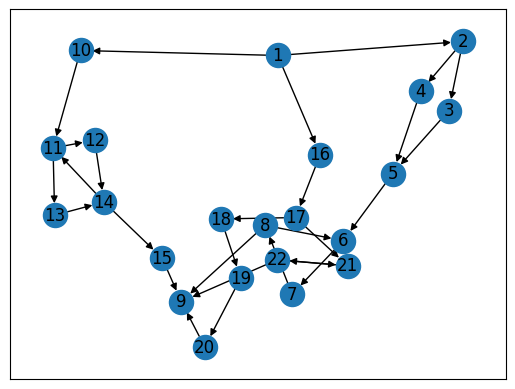

In [38]:
import networkx as nx

nx.draw_networkx(graph.nx_graph)

## all simple paths

In [6]:
paths_generator = nx.all_simple_edge_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)

In [7]:
paths

[[(1, 2), (2, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 2), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 10), (10, 11), (11, 12), (12, 14), (14, 15), (15, 9)],
 [(1, 10), (10, 11), (11, 13), (13, 14), (14, 15), (15, 9)],
 [(1, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 9)],
 [(1, 16), (16, 17), (17, 21), (21, 22), (22, 9)]]

In [8]:
from src.sample_dialogue import materialize_dialogue

pprint(materialize_dialogue(graph.nx_graph, paths[-1]))

[{'participant': 'assistant',
  'text': 'Do you want to choose a book, a movie, or a game?'},
 {'participant': 'user', 'text': 'Can you recommend a video game?'},
 {'participant': 'assistant',
  'text': "You're looking for a video game recommendation."},
 {'participant': 'user', 'text': "I'm interested in a specific genre of game."},
 {'participant': 'assistant', 'text': 'Which genre of games do you prefer?'},
 {'participant': 'user', 'text': 'Tell me about the reviews for this game.'},
 {'participant': 'assistant',
  'text': 'What are the reviews like for this game?'},
 {'participant': 'user', 'text': "Tell me more about the game's features."},
 {'participant': 'assistant', 'text': 'What are the features of this game?'},
 {'participant': 'user', 'text': "I'll definitely play this one."},
 {'participant': 'assistant', 'text': 'It seems like a great choice for you.'}]


## simple cycles

In [9]:
import itertools as it

all_cycles = nx.recursive_simple_cycles(graph.nx_graph)
set(it.chain.from_iterable(all_cycles))

{6, 7, 8, 11, 12, 13, 14, 21, 22}

In [48]:
def find_possible_cycles(nx_graph: nx.DiGraph | nx.MultiGraph, path: list[int]):
    path_nodes_set = set(path)
    all_cycles = nx.recursive_simple_cycles(nx_graph)
    res = filter(
        lambda cycle: len(set(cycle) & path_nodes_set) > 0,
        all_cycles
    )
    return list(res)


def get_repeated_cycle(cycle: list[int], n_repeats: int):
    res = cycle * n_repeats
    return res


def get_node2cycle_dict(cycles: list[list[int]]):
    """mapping: node_id -> list of cycle ids where this node is occured"""
    res = {}
    for i_cycle, cycle in enumerate(cycles):
        for node_id in cycle:
            res[node_id] = res.get(node_id, []) + [i_cycle]
    return res


def get_sorted_cycles(path: list[int], cycles: list[list[int]]):
    node2cycle = get_node2cycle_dict(cycles)    

    ids_within_path = []        # index of node met in kth cycle
    sorted_cycles = []      # cycles sorted in order of appearance on the path

    for i, node_id in enumerate(path):
        cycle_ids = node2cycle.get(node_id, None)
        
        if not cycle_ids:
            continue
        
        cur_cycles = [cycles[j] for j in cycle_ids]
        if i > 0:
            cur_cycles = [c for c in cur_cycles if path[i-1] not in c]
        cur_cycles = [cycle_shift_to_head(c, node_id) for c in cur_cycles]

        if len(cur_cycles) > 0:
            ids_within_path.append(i * len(cur_cycles))
            sorted_cycles.extend(cur_cycles)

    return sorted_cycles, ids_within_path


def repeat_and_insert_cycles(path: list[int], cycles: list[list[int]], indexes: list[int], n_repeats: list[int]):
    res = path[:]
    n_repeats_gen = iter(n_repeats)
    
    for cycle, i in zip(cycles[::-1], indexes[::-1]):
        repeated_cycle = get_repeated_cycle(cycle, next(n_repeats_gen, n_repeats[-1]))
        for node_id in repeated_cycle[::-1]:
            res.insert(i, node_id)

    return res


def cycle_shift_to_head(lst: list, head_elem):
    i = lst.index(head_elem)
    return lst[i:] + lst[:i]


def concat_lists(lists: list[list]):
    res = []
    for lst in lists:
        res.extend(lst)
    return res


def add_cycles(nx_graph, path: list[int], n_cycles: int, n_repeats: list[int]):
    assert n_cycles >= len(n_repeats)

    possible_cycles = find_possible_cycles(nx_graph, path)
    n_possible_cycles = len(possible_cycles)
   
    if n_cycles > n_possible_cycles:
        print(f'demanded {n_cycles=} is larger than number of unique cycles that can be added to provided path ({n_possible_cycles=})')
        print('set n_cycles to n_possible_cycles')
        n_cycles = n_possible_cycles
        n_repeats = n_repeats[:n_cycles]
        cycles = possible_cycles
    else:
        cycles = possible_cycles[:n_cycles]
    
    sorted_cycles, indexes_to_insert = get_sorted_cycles(path, cycles)
    res = repeat_and_insert_cycles(path, sorted_cycles, indexes_to_insert, n_repeats)
    
    return res
    

In [49]:
paths_generator = nx.all_simple_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

[[1, 2, 3, 5, 6, 7, 8, 9],
 [1, 2, 4, 5, 6, 7, 8, 9],
 [1, 10, 11, 12, 14, 15, 9],
 [1, 10, 11, 13, 14, 15, 9],
 [1, 16, 17, 18, 19, 20, 9],
 [1, 16, 17, 21, 22, 9]]

In [57]:
add_cycles(graph.nx_graph, paths[2], n_cycles=3, n_repeats=[1])

demanded n_cycles=3 is larger than number of unique cycles that can be added to provided path (n_possible_cycles=2)
set n_cycles to n_possible_cycles


[1, 10, 11, 12, 11, 13, 14, 14, 11, 13, 14, 15, 9]

In [31]:
[1,2,3] * 2

[1, 2, 3, 1, 2, 3]